In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import pprint as pp

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from lmfit import Parameters, fit_report, minimize
from shapely.geometry import Point
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

plt.style.use("ggplot")

In [3]:
nve_data_year = 2023
st_yr, end_yr = 2013, 2021
calib_inputs = [
    # "agriculturebackground_tdp_kg",
    # "agriculturebackground_tpp_kg",
    "agriculture_tdp_kg",
    "agriculture_tpp_kg",
    # "aquaculture_tdp_kg",
    # "aquaculture_tpp_kg",
    # "industry_tdp_kg",
    # "industry_tpp_kg",
    # "largewastewater_tdp_kg",
    # "largewastewater_tpp_kg",
    # "spredt_tdp_kg",
    # "spredt_tpp_kg",
    # "upland_tdp_kg",
    # "upland_tpp_kg",
    # "urban_tdp_kg",
    # "urban_tpp_kg",
    # "wood_tdp_kg",
    # "wood_tpp_kg",
    # "trans_tdp",
    # "trans_tpp",
]
fac_min, fac_max = 0.1, 6
eval_pars = ["tdp", "tpp", "totp"]

csv_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [4]:
def read_observed(eval_pars):
    """Read observed fluxes."""
    obs_csv = os.path.join(eval_fold, "rid_vannmiljo_obs_data_aggregated.csv")
    obs_df = pd.read_csv(obs_csv)
    obs_df[obs_df == 0] = np.nan
    obs_df.dropna(how="any", inplace=True)

    # Get just pars of interest
    cols = [f"{par.upper()}_tonnes" for par in eval_pars]
    obs_df = obs_df[["station_id", "regine", "year"] + cols]

    # Convert to long
    obs_df = obs_df.melt(
        id_vars=["station_id", "regine", "year"], value_name="observed"
    )

    return obs_df


def validate_input(calib_inputs, st_yr, end_yr, fac_min, fac_max):
    """Validate user input."""
    all_inputs = [
        "agriculturebackground_din_kg",
        "agriculturebackground_ss_kg",
        "agriculturebackground_tdp_kg",
        "agriculturebackground_toc_kg",
        "agriculturebackground_ton_kg",
        "agriculturebackground_totn_kg",
        "agriculturebackground_totp_kg",
        "agriculturebackground_tpp_kg",
        "agriculture_din_kg",
        "agriculture_ss_kg",
        "agriculture_tdp_kg",
        "agriculture_toc_kg",
        "agriculture_ton_kg",
        "agriculture_totn_kg",
        "agriculture_totp_kg",
        "agriculture_tpp_kg",
        "aquaculture_din_kg",
        "aquaculture_tdp_kg",
        "aquaculture_toc_kg",
        "aquaculture_ton_kg",
        "aquaculture_totn_kg",
        "aquaculture_totp_kg",
        "aquaculture_tpp_kg",
        "glacier_ss_kg",
        "industry_din_kg",
        "industry_ss_kg",
        "industry_tdp_kg",
        "industry_toc_kg",
        "industry_ton_kg",
        "industry_totn_kg",
        "industry_totp_kg",
        "industry_tpp_kg",
        "lake_din_kg",
        "largewastewater_din_kg",
        "largewastewater_ss_kg",
        "largewastewater_tdp_kg",
        "largewastewater_toc_kg",
        "largewastewater_ton_kg",
        "largewastewater_totn_kg",
        "largewastewater_totp_kg",
        "largewastewater_tpp_kg",
        "spredt_din_kg",
        "spredt_tdp_kg",
        "spredt_toc_kg",
        "spredt_ton_kg",
        "spredt_totn_kg",
        "spredt_totp_kg",
        "spredt_tpp_kg",
        "upland_din_kg",
        "upland_ss_kg",
        "upland_tdp_kg",
        "upland_toc_kg",
        "upland_ton_kg",
        "upland_totn_kg",
        "upland_totp_kg",
        "upland_tpp_kg",
        "urban_din_kg",
        "urban_ss_kg",
        "urban_tdp_kg",
        "urban_toc_kg",
        "urban_ton_kg",
        "urban_totn_kg",
        "urban_totp_kg",
        "urban_tpp_kg",
        "wood_din_kg",
        "wood_ss_kg",
        "wood_tdp_kg",
        "wood_toc_kg",
        "wood_ton_kg",
        "wood_totn_kg",
        "wood_totp_kg",
        "wood_tpp_kg",
        "trans_din",
        "trans_ss",
        "trans_tdp",
        "trans_toc",
        "trans_ton",
        "trans_totn",
        "trans_totp",
        "trans_tpp",
    ]
    assert set(calib_inputs).issubset(set(all_inputs)), "Unrecognised input variables."
    assert st_yr < end_yr, "'st_yr' must be less than 'end_yr'."
    assert fac_max > fac_min, "'fac_min' must be less than 'fac_max'."
    assert st_yr >= 2013, "'st_yr' cannot be borefore 2013."
    assert (fac_max > 0) and (
        fac_min > 0
    ), "'fac_min' and 'fac_max' must be greater than zero."


def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


def run_model(params, st_yr, end_yr, eval_pars):
    """ """
    # Get relevant observed data
    obs_df = read_observed(eval_pars)
    obs_df = obs_df.query("@st_yr <= year <= @end_yr")

    # Run TEOTIL3
    years = range(st_yr, end_yr + 1)
    df_list = []
    for year in years:
        csv_path = os.path.join(
            csv_fold,
            f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
        )
        in_df = pd.read_csv(csv_path)
        in_df.columns = in_df.columns.str.replace("-", "")

        # Reduce number of columns for speed
        cols = [
            col for col in in_df.columns if any(f"_{par}" in col for par in eval_pars)
        ]
        in_df = in_df[
            ["regine", "regine_down", "a_cat_land_km2", "runoff_mm/yr", "q_cat_m3/s"]
            + cols
        ]

        # Apply calibration parameters
        for par_name, par_value in params.items():
            in_df[par_name] = in_df[par_name] * par_value

        # Run TEOTIL
        g = teo.model.run_model(
            in_df,
            id_col="regine",
            next_down_col="regine_down",
            totals_from_subfracs=True,
        )
        res_df = teo.model.model_to_dataframe(
            g, id_col="regine", next_down_col="regine_down"
        )
        res_df["year"] = year
        df_list.append(res_df)
    mod_df = pd.concat(df_list, axis="rows")

    # Reshape
    cols = [col for col in mod_df.columns if col.startswith("accum_")]
    mod_df = mod_df[["regine", "year"] + cols].copy()
    cols = [remove_prefix(col, "accum_") for col in cols]
    mod_df.columns = ["regine", "year"] + cols
    for par in eval_pars:
        cols = [col for col in mod_df.columns if f"_{par}_" in col]
        mod_df[f"{par.upper()}_tonnes"] = mod_df[cols].sum(axis="columns") / 1000
    cols = [f"{par.upper()}_tonnes" for par in eval_pars]
    mod_df = mod_df[["regine", "year"] + cols]

    # Convert to long
    mod_df = mod_df.melt(id_vars=["regine", "year"], value_name="modelled")

    # Join
    res_df = pd.merge(obs_df, mod_df, how="left", on=["regine", "year", "variable"])

    return res_df


def residual(params, st_yr, end_yr, eval_pars):
    """ """
    res_df = run_model(params, st_yr, end_yr, eval_pars)

    residual = res_df["observed"] - res_df["modelled"]

    return residual

In [5]:
%%time

validate_input(calib_inputs, st_yr, end_yr, fac_min, fac_max)

# Build parameters
params = Parameters()
for calib_input in calib_inputs:
    if calib_input.startswith('trans_'):
        params.add(calib_input, value=0.5, min=0, max=1, vary=True)
    else:
        params.add(calib_input, value=1, min=fac_min, max=fac_max, vary=True)

res = minimize(
    residual, params, args=(st_yr, end_yr, eval_pars), nan_policy="omit"
)
print(fit_report(res))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 561
    # variables        = 2
    chi-square         = 230265.458
    reduced chi-square = 411.923896
    Akaike info crit   = 3379.68689
    Bayesian info crit = 3388.34633
[[Variables]]
    agriculture_tdp_kg:  4.87424574 +/- 0.12436270 (2.55%) (init = 1)
    agriculture_tpp_kg:  1.73339715 +/- 0.08058626 (4.65%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(agriculture_tdp_kg, agriculture_tpp_kg) = -0.4996
CPU times: user 24min 18s, sys: 12.2 s, total: 24min 30s
Wall time: 24min 32s


In [6]:
res_df = run_model(res.params, st_yr, end_yr, eval_pars)

<Axes: xlabel='observed', ylabel='modelled'>

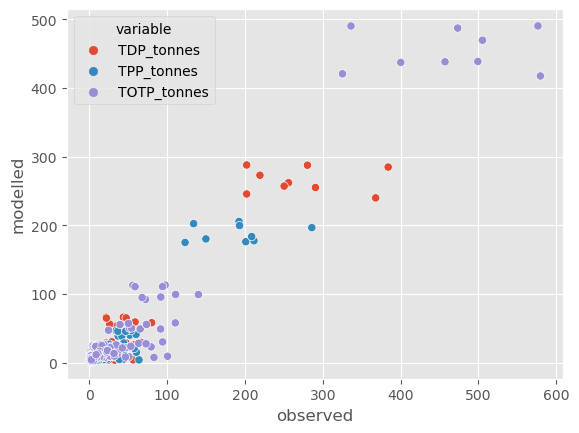

In [7]:
sn.scatterplot(res_df, x="observed", y="modelled", hue="variable")

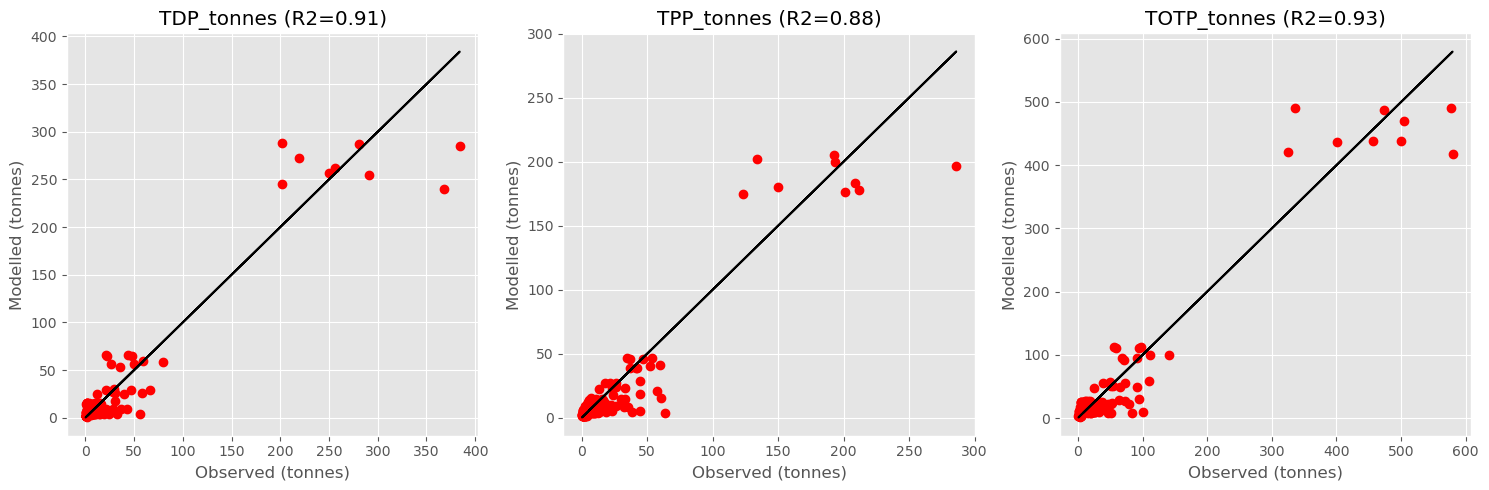

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
par_list = res_df["variable"].unique().tolist()
for idx, par in enumerate(par_list):
    par_df = res_df.query("variable == @par").copy()
    r2 = r2_score(par_df["observed"], par_df["modelled"])
    axes[idx].plot(par_df["observed"], par_df["modelled"], "ro")
    axes[idx].plot(par_df["observed"], par_df["observed"], "k-", label="1:1 line")
    axes[idx].set_title(f"{par} (R2={r2:.2f})")
    axes[idx].set_xlabel("Observed (tonnes)")
    axes[idx].set_ylabel("Modelled (tonnes)")
    # axes[idx].set_xscale('log')
    # axes[idx].set_yscale('log')
plt.tight_layout()

In [9]:
# pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]
# teo2_pars = ["TOTN", "TOTP"]
# stn_list = comp_df["station_id"].unique().tolist()
# par = "TOTP"

# par_cols = [
#     col for col in comp_df.columns if par.lower() in (i.lower() for i in col.split("_"))
# ]

# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
# axes = axes.flatten()
# fig.delaxes(axes[-1])

# for idx, stn_id in enumerate(stn_list):
#     stn_comp_df = comp_df.query("station_id == @stn_id").set_index("year")[par_cols]

#     stn_comp_df.drop(columns=[f"{par}_tonnes"]).plot(
#         kind="bar", stacked=True, ax=axes[idx], legend=False, cmap="tab10"
#     )

#     axes[idx].plot(
#         stn_comp_df.index - stn_comp_df.index.min(),
#         stn_comp_df[f"{par}_tonnes"],
#         marker="o",
#         color="red",
#         label="Observed",
#     )
#     if par in teo2_pars:
#         teo2_stn_df = teo2_df.query("station_id == @stn_id").set_index("year")
#         axes[idx].plot(
#             teo2_stn_df.index - teo2_stn_df.index.min(),
#             teo2_stn_df[f"all_sources_{par.lower()}_tonnes"],
#             marker="o",
#             color="black",
#             label="TEOTIL2",
#         )
#     axes[idx].set_title(stn_id)
#     axes[idx].set_ylabel(f"{par} (tonnes)")
# plt.tight_layout()

# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(0.95, 0.05), ncol=1)

In [10]:
# pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]

# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# axes = axes.flatten()
# fig.delaxes(axes[-1])

# for idx, par in enumerate(pars):
#     par_cols = [
#         col
#         for col in comp_df.columns
#         if par.lower() in (i.lower() for i in col.split("_"))
#     ]
#     reg_df = comp_df.set_index("year")[par_cols]
#     obs = reg_df[f"{par}_tonnes"]
#     mod = reg_df.drop(columns=[f"{par}_tonnes"]).sum(axis="columns")
#     reg_df = pd.DataFrame({"mod": mod, "obs": obs}).query("(mod > 0) and (obs > 0)")
#     axes[idx].plot(reg_df["obs"], reg_df["mod"], "ro")
#     axes[idx].plot(reg_df["obs"], reg_df["obs"], "k-", label="1:1 line")
#     axes[idx].set_title(par)
#     axes[idx].set_xlabel("Observed (tonnes)")
#     axes[idx].set_ylabel("Modelled (tonnes)")
#     # axes[idx].set_xscale('log')
#     # axes[idx].set_yscale('log')
#     # axes[idx].set_xlim((0,200))
#     # axes[idx].set_ylim((0,200))
# plt.tight_layout()